Option+Shift+F pour formatter
cmd+maj +7 commenter

In [1]:
from typing import Tuple, List, List, Dict
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation, generate_binary_structure

In [2]:
Node = Tuple[int,int]

In [3]:
def reconstruct_path(cameFrom: Dict[Node, Node], current: Node) -> List[Node]:
    # TODO docstring

    # """
    # Recurrently reconstructs the path from start node to the current node
    # :param cameFrom: map (dictionary) containing for each node n the node immediately
    #                  preceding it on the cheapest path from start to n
    #                  currently known.<
    # :param current: current node (x, y)
    # :return: list of nodes from start to current node
    # """

    total_path: List[Node] = [current]
    while current in cameFrom.keys():
        total_path.insert(0, cameFrom[current])
        current = cameFrom[current]
    return total_path

In [4]:
def get_movements(movement_type: str) -> List[Tuple[int, int, float]]:
    if movement_type == "4N":
        return _get_movements_4n()
    elif movement_type == "8N":
        return _get_movements_8n()
    else:
        raise ValueError("Unknown movement")


def _get_movements_4n() -> List[Tuple[int, int, float]]:
    # TODO docstring
    # """
    # Get all possible 4-connectivity movements (up, down, left right).
    # :return: list of movements with cost [(dx, dy, movement_cost)]
    # """
    return [
        (1, 0, 1.0),
        (0, 1, 1.0),
        (-1, 0, 1.0),
        (0, -1, 1.0),
    ]


def _get_movements_8n() -> List[Tuple[int, int, float]]:
    # TODO docstring
    # """
    # Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    # (up, down, left, right and the 4 diagonals).
    # :return: list of movements with cost [(dx, dy, movement_cost)]
    # """
    s2 = math.sqrt(2)
    return [
        (1, 0, 1.0),
        (0, 1, 1.0),
        (-1, 0, 1.0),
        (0, -1, 1.0),
        (1, 1, s2),
        (-1, 1, s2),
        (-1, -1, s2),
        (1, -1, s2),
    ]

In [5]:
def orientation(parent: Node, current: Node) -> Tuple[int, int]:
    return (current[0] - parent[0], current[1] - parent[1])


def turn_cost(parent:Node, current: Node, neighbor:Node, alpha : float = 1) -> float:
    current_orientation : Tuple[int, int] = orientation(parent, current)
    next_orientation : Tuple[int, int] = orientation(current, neighbor)
    turn = abs((current_orientation[0]-next_orientation[0])) + abs((current_orientation[1]-next_orientation[1]))
    return alpha*turn

In [6]:
def A_Star(
    maze: np.ndarray,
    start: Node,
    goal: Node,
    movement_type: str = "8N",
):
    # TODO docstring
    # """
    # A* for 2D occupancy grid. Finds a path from start to goal.
    # h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    # :param start: start node (x, y)
    # :param goal_m: goal node (x, y)
    # :param maze: the grid map
    # :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    # :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    # """
    for point in [start, goal]:
        assert (
            0 <= point[0] <= maze.shape[0] and 0 <= point[1] <= maze.shape[1]
        ), "start or end goal not contained in the map"

    if maze[start[0], start[1]]:
        raise Exception("Start node is not traversable")

    if maze[goal[0], goal[1]]:
        raise Exception("Goal node is not traversable")

    openList: List[Node] = [start]
    closedList: List[Node] = []
    cameFrom: Dict[Node, Node] = {start: (-1,-1)} # dépend de l'orientation du robot

    gScore: np.ndarray = np.ones(maze.shape) * np.inf
    gScore[start] = 0

    hScore: np.ndarray = np.array(
        [
            [
                abs((row - goal[0]) + (abs(col - goal[1])))
                for col in range(maze.shape[1])
            ]
            for row in range(maze.shape[0])
        ]
    )

    fScore: np.ndarray = np.ones(maze.shape) * np.inf
    fScore[start] = gScore[start] + hScore[start]
    
    def get_fScore(position: Node)-> float :
            return fScore[position]

    while openList:
        
        current : Node = min(openList, key=get_fScore)

        if current == goal:
            return reconstruct_path(cameFrom, current)

        openList.remove(current)
        closedList.append(current)

        for dx, dy, deltacost in get_movements(movement_type):

            neighbor : Node = (current[0] + dx, current[1] + dy)

            if (
                (neighbor[0] >= maze.shape[0])
                or (neighbor[1] >= maze.shape[1])
                or (neighbor[0] < 0)
                or (neighbor[1] < 0)
            ):
                continue

            if (maze[neighbor[0], neighbor[1]]) or (neighbor in closedList):
                continue

            if neighbor not in openList:
                openList.append(neighbor)
                cameFrom[neighbor] = current
                gScore[neighbor] = gScore[current] + deltacost + turn_cost(cameFrom[current], current, neighbor)
                fScore[neighbor] = gScore[neighbor] + hScore[neighbor] 

    print("No path found to goal")
    return []

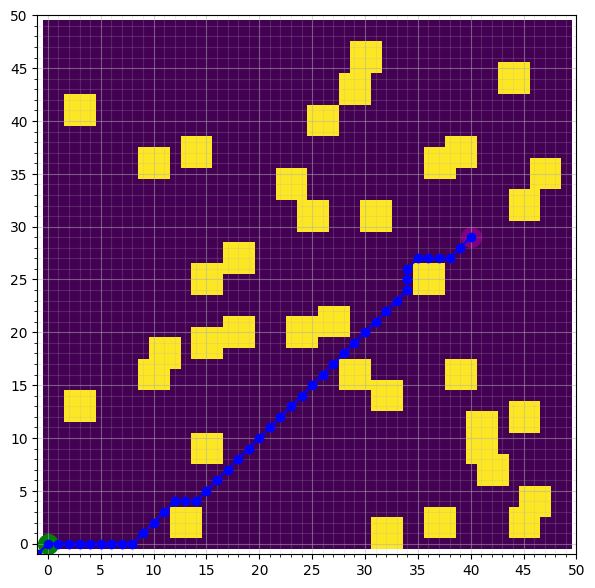

In [10]:
np.random.seed(seed=6)
maze = np.random.randint(2, size=(50,50))
for i in range(5):
    maze = maze*np.random.randint(2, size=(50,50))


struct = generate_binary_structure(2, 2)
# iteration for size 
# structure pour diagonal or not 
maze = binary_dilation(maze, structure=struct, iterations=1)

start:Tuple[int,int] = (0, 0)
end = (40, 29)

path = A_Star(maze, start, end)
path_1 = np.array(path).reshape(-1, 2).transpose()


def create_empty_plot(max_val_x,max_val_y):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    
    major_ticks_x = np.arange(0, max_val_x+1, 5)
    minor_ticks_x = np.arange(0, max_val_x+1, 1)
    major_ticks_y = np.arange(0, max_val_y+1, 5)
    minor_ticks_y = np.arange(0, max_val_y+1, 1)
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val_y])
    ax.set_xlim([-1,max_val_x])
    ax.grid(True)
    
    return fig, ax

fig_astar, ax_astar = create_empty_plot(maze.shape[0],maze.shape[1])
ax_astar.imshow(maze.transpose())
ax_astar.plot(path_1[0], path_1[1], marker="o", color = 'blue');
ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
ax_astar.scatter(end[0], end[1], marker="o", color = 'purple', s=200);

(44, 2)

source : https://codereview.stackexchange.com/questions/28207/finding-the-closest-point-to-a-list-of-points

In [73]:
def distance_to_path(
    position: Tuple[float,float],
    path: List[Node],
    absolute : bool = True,
)-> float:
    path = np.asarray(path)
    print(path.shape)
    position = np.asarray(position)
    dist_2 = np.sum((path - position)**2, axis=1)
    min1_idx, min2_idx = np.argpartition(dist_2, 1)[0:2]   
    area = np.cross(position-path[min1_idx,:],position-path[min2_idx,:])
    print(path[min1_idx,:] - path[min2_idx,:])
    diagonal = np.linalg.norm(path[min1_idx,:] - path[min2_idx,:],2)
    distance = area/diagonal
    if absolute:
        distance = abs(distance)
    return distance
    
    
    
    


In [74]:
distance_to_path((20,11),path)

(44, 2)
[-1 -1]


0.7071067811865475

In [9]:

# maze = np.array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],])

# star = (0, 0)
# end = (7, 6)

# height, width = 10,8


# hScore = np.array([[(abs(col-end[1])+abs((row-end[0])))for col in range(width)]for row in range(height)])
# hScore[end]=100
# print(hScore)

# np.ones((height, width))
# #path = astar(maze, start, end)
# #print(path)

# openList = [(1,3), (2,4), (5,6)]

# def get_fScore(position):
#     return hScore[position]

# # the node in openList having the lowest fScore[] value
# current = min(openList, key=get_fScore)
# print(current)

a = set()
a.add(1)
a.remove(1)
if a: 
    print("hi")